# setting 

## path

In [1]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Credit_Comp/py/models/')
sys.path.append(home_path + '/Desktop/Credit_Comp/py/')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg')

## module

In [16]:
## module
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas_profiling as pdp
from collections import Counter
import scipy
import Base, Classifier # my module
# genetic algorithm
from deap import algorithms, base, creator, tools, gp
import operator, math, time
from tqdm import tqdm
# optuna
from functools import partial
import optuna
# sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.externals.six import StringIO
import sklearn.preprocessing as preproc
# Boosting
from xgboost import XGBClassifier
import lightgbm as lgb
# view
import pydotplus
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [3]:
# moduleの再読み込み(作業中に更新した内容をここで更新できる)
import importlib
importlib.reload(Base)
importlib.reload(Classifier)

# for instance
Process = Base.Process()
Applicate = Base.Applicate()
LightGBM = Classifier.LightGBM()
DecisionTree = Classifier.DecisionTree()

## read data

In [8]:
# base data
train_base, test_base, target = Process.read_data1()

# select features
features_base = test_base.columns.values # 暫定的

27000 observations and 24 features in train set.
3000 observations and 23 features in test set.


# Feature engineering

- 機械学習のための特徴量エンジニアリングを参考に

In [19]:
def feature_engineering(data):
    data['Y11'] = np.log10(data['X1'] + 1) # 対数変換
    tmp1, tmp2 = scipy.stats.boxcox(data['X1']) # Box-Cox変換 (分散安定化)
    data['Y12'] = tmp1
    data['Y13'] = preproc.StandardScaler().fit_transform(data[['X1']])
    # data['X1'] = np.floor(np.log10(data['X1'] + 1)) # 対数変換 + 離散化 (指数幅の階級割り当て)
    data['Y5'] = np.floor_divide(data['X5'], 10) # 離散化 (固定幅)
    return data

In [20]:
# execute
train = feature_engineering(train_base.copy())
test = feature_engineering(test_base.copy())
features = test.columns.values

In [21]:
# check
print(train.head())
print(train_base.head())

       X1  X2  X3  X4  X5  X6  X7  X8  X9  X10 ...    X19    X20   X21   X22  \
0   20000   2   2   1  24   2   2  -1  -1   -2 ...    689      0     0     0   
1  120000   2   2   2  26  -1   2   0   0    0 ...   1000   1000  1000     0   
2   90000   2   2   2  34   0   0   0   0    0 ...   1500   1000  1000  1000   
3   50000   1   2   1  57  -1   0  -1   0    0 ...  36681  10000  9000   689   
4   50000   1   1   2  37   0   0   0   0    0 ...   1815    657  1000  1000   

    X23  y       Y11        Y12       Y13  Y5  
0     0  1  4.301052  49.022150 -1.135245   2  
1  2000  1  5.079185  81.420412 -0.362214   2  
2  5000  0  4.954247  75.119764 -0.594123   3  
3   679  0  4.698979  63.658328 -0.903336   5  
4   800  0  4.698979  63.658328 -0.903336   3  

[5 rows x 28 columns]
       X1  X2  X3  X4  X5  X6  X7  X8  X9  X10 ...    X15    X16    X17   X18  \
0   20000   2   2   1  24   2   2  -1  -1   -2 ...      0      0      0     0   
1  120000   2   2   2  26  -1   2   0   0    0

# model comparing

- base lightgbm + new lightgbm
- base Decision Tree + new Decision Tree

In [22]:
# parameters
tree_param = Process.open_parameter(file_name = 'Tree_classifer_param')
lgb_param = Process.open_parameter(file_name = 'lgb_classifer_param')
# model
lgb_base, importances = LightGBM.validation(train_base,features_base,lgb_param,name="Lightgbm base model")
# lgb_new, importances = LightGBM.validation(train_base,features_base,param,name="Lightgbm new model")
lgb_new, importances = LightGBM.validation(train,features,lgb_param,name="Lightgbm new model")
tree_base = DecisionTree.validation(train_base,features_base,tree_param, name="Decision Tree base model")
tree_new = DecisionTree.validation(train,features,tree_param, name="Decision Tree new model")

# result
performance = pd.concat([lgb_base,lgb_new,tree_base,tree_new])
g_normal = ggplot(performance,aes(x='fold',y='score',group = 'model',color = 'model')) + geom_point() + geom_line()
print(g_normal)

fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.164099	valid_1's binary_error: 0.173481
[200]	training's binary_error: 0.151506	valid_1's binary_error: 0.176444
[300]	training's binary_error: 0.137877	valid_1's binary_error: 0.175704
Early stopping, best iteration is:
[119]	training's binary_error: 0.161086	valid_1's binary_error: 0.172
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.16242	valid_1's binary_error: 0.181481
[200]	training's binary_error: 0.150272	valid_1's binary_error: 0.183704
Early stopping, best iteration is:
[46]	training's binary_error: 0.168938	valid_1's binary_error: 0.178963
fold n°3
Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.160593	valid_1's binary_error: 0.183556
[200]	training's binary_error: 0.148494	valid_1's binary_error: 0.186815
Early stopping, best iteration is:
[32]	training's binary_erro

In [72]:
print(lgb_base)
print(lgb_new)

   fold                model     score
0     1  Lightgbm base model  0.495437
1     2  Lightgbm base model  0.482434
2     3  Lightgbm base model  0.478057
3     4  Lightgbm base model  0.469467
   fold               model     score
0     1  Lightgbm new model  0.495437
1     2  Lightgbm new model  0.482434
2     3  Lightgbm new model  0.478057
3     4  Lightgbm new model  0.469467


In [79]:
performance

,fold,model,score
0,1,Lightgbm base model,0.495437
1,2,Lightgbm base model,0.482434
2,3,Lightgbm base model,0.478057
3,4,Lightgbm base model,0.469467
0,1,Lightgbm new model,0.495437
1,2,Lightgbm new model,0.482434
2,3,Lightgbm new model,0.478057
3,4,Lightgbm new model,0.469467
0,1,Decision Tree base model,0.487987
1,2,Decision Tree base model,0.479023


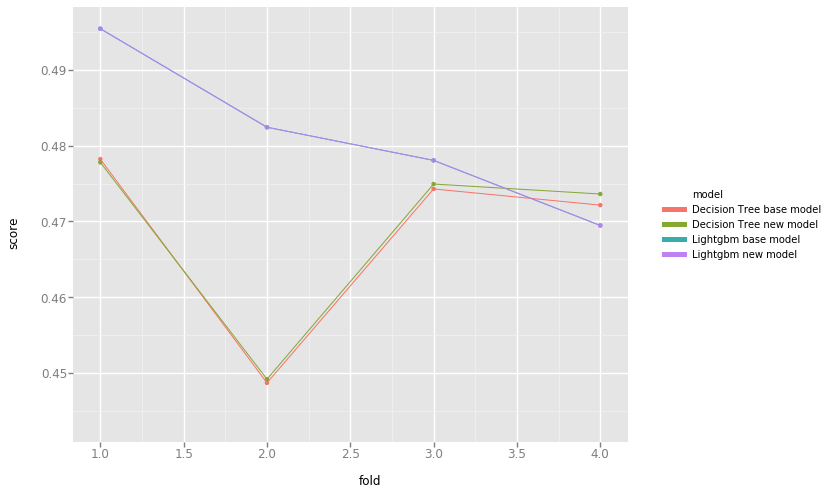

<ggplot: (-9223372036548696071)>


In [23]:
g_normal = ggplot(performance,aes(x='fold',y='score',group = 'model',color = 'model')) + geom_point() + geom_line()
print(g_normal)

In [24]:
features

array(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20',
       'X21', 'X22', 'X23', 'Y11', 'Y12', 'Y13', 'Y5'], dtype=object)